In [1]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from scipy.stats import multivariate_normal 
from scipy.stats import invwishart 

from sklearn import metrics
from scipy.special import psi
from scipy.special import digamma 

from scipy.special import gammaln, psi
from numpy.linalg import slogdet, inv


In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

We want to compute the intractable GMM posterior:
$$
    p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X}) = \frac{p(\mathbf{X},\boldsymbol{\phi},\mathbf{z},\boldsymbol{\pi})}{p(\mathbf{X})}
$$

Introduce approximating distribution $q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})$ where we use KL divergence as a cost function 
$$
    \mathbb{KL}(q||p) = \sum_{\mathbf{z},\boldsymbol{\phi}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X})}
$$

Objective : 
$$\begin{align}
    \mathcal{J}(q) &= \mathbb{KL}(q||p) = \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X})}d\boldsymbol{\pi} d\boldsymbol{\phi}\\\\

    &=  \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})d\boldsymbol{\phi}d\boldsymbol{\pi} - \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X})d\boldsymbol{\pi}d\boldsymbol{\phi}\\\\

    &= \Big\langle \log q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})} - \Big\langle \log p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}\\

    &= \Big\langle \log q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z}, 
       \boldsymbol{\phi},\boldsymbol{\pi})} -
       \Big\langle \log p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})} + 
       \Big\langle  \log p(\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}\\\\

    &= \Big\langle  \log \frac{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}{p(\mathbf{X})} \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}  + 
       \log p(\mathbf{X}) \\\\
    
    &= \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X})\Big) + \underbrace{\log p(\mathbf{X})}_{\text{constant}}
\end{align}$$

Objective can simplify to
$$\begin{align}
    q* &\leftarrow \argmin_{q} \left[  \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X})\Big)  + \underbrace{\log p(\mathbf{X})}_{\text{constant}} \right]\\
        &= \argmin_{q} \left[ \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X})\Big) \right]
\end{align}$$

---

## Mean Field 

Mean Field (Structured) Independence Simplifying Assumption
$$\begin{align}
    q(\boldsymbol{\pi},\boldsymbol{\phi},\mathbf{z},\mathbf{X}_H)& = 
        \underbrace{q(\boldsymbol{\pi})}_{\text{Dirichlet}}\quad
        \underbrace{q(\boldsymbol{\phi})}_{\text{Gaussian}}\quad
        \underbrace{q(\mathbf{z})}_{\text{Cat}}\quad
        \underbrace{q(\mathbf{X}_H)}_{\text{Bernoulli}}\\

        &=  q(\mathbf{z}, \mathbf{X}_H) \cdot
            \prod_K^K q(\boldsymbol{\pi}_k) q(\boldsymbol{\phi}_k)
\end{align}$$

Update Steps 

$$\begin{align}
    &\ln q(\boldsymbol{\phi},\boldsymbol{\pi}) = \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}  + \text{const}\\\\
    
    &\ln q(\mathbf{z},\mathbf{X}_H) = \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}
\end{align}$$

Posterior
$$
    p(\mathbf{X}_O,\mathbf{X}_H,\boldsymbol{\phi},\mathbf{z},\boldsymbol{\pi}) \propto p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\phi},\mathbf{z})p(\boldsymbol{\phi})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})
$$

### Updates for variational posterior of model parameters $q(\boldsymbol{\phi},\boldsymbol{\pi})$

$$\begin{align}
    \log q(\boldsymbol{\phi},\boldsymbol{\pi}) &= \Big\langle \log p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}  + \text{const}\\\\

    &= \Big\langle \log p(\mathbf{X}_O,\mathbf{X}_H|\mathbf{z},\boldsymbol{\phi}) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)} 
       + \Big\langle \log p(\boldsymbol{\phi})\Big\rangle_{q(\mathbf{z})} 
       + \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} 
       + \text{const}\\\\

    &= \underbrace{\log p(\boldsymbol{\phi}) 
       + \Big\langle \log p(\mathbf{X}_O,\mathbf{X}_H|\mathbf{z},\boldsymbol{\phi})}_{\text{Terms containing $\boldsymbol{\phi}$}} \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}
       + \underbrace{\Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \log p(\boldsymbol{\pi})}_{\text{Terms containing $\pi$}}
\end{align}$$

Can separate RHS into terms containing $\pi$ and $\mu$




#### Update Step for $q(\boldsymbol{\pi})$

$$\begin{align}
    \log q(\boldsymbol{\pi}) &= \log p(\boldsymbol{\pi}) + \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0) + \Big\langle \sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \Big[ \frac{1}{B(\alpha_0)}\prod_k^K \pi_k^{\alpha_0 - 1} \Big] + \Big\langle \sum_n^N \sum_k^K \log \pi_{k}^{z_{nk}} \Big\rangle_{q(\mathbf{z})} + \text{const} \\
       
    &= \underbrace{-\log B(\alpha_0)}_{\text{Independent of $\pi$}} + \sum_k^K \log \pi_k^{\alpha_0 - 1} +
       \Big\langle \sum_k^K \sum_n^N z_{nk}\log \pi_{k} \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N \Big\langle z_{nk} \Big\rangle_{q(\mathbf{z})} \log \pi_{k} + \text{const}, \quad -\log B(\alpha_0) \text{ absorbed into const}\\

    &= \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N r_{nk} \log \pi_{k} + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \log \pi_{k} \sum_n^N r_{nk} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 + N_k -1) \log \pi_k  \Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk} \\

    \implies & \boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\

\end{align}$$

#### Update step for $q(\boldsymbol{\phi})$

Here $\boldsymbol{\phi}=\{\boldsymbol{\mu},\boldsymbol{\Sigma}\}$, however we update $\Sigma$ via M-Step optimization. Hence,
$$
    q(\boldsymbol{\phi}) = q(\boldsymbol{\mu}|\hat{\boldsymbol{\Sigma}}), \quad \text{where } \hat{\boldsymbol{\Sigma}} \leftarrow \argmax_{\boldsymbol{\Sigma}} \Big\langle p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\mathbf{z},\boldsymbol{\mu})}
$$

Hence assuming an Inverse Wishart over $\boldsymbol{\Sigma}$,
$$\begin{align}
    \hat{\boldsymbol{\Sigma}} =& \frac{\mathbf{S}_0 + \mathbf{S}_{k}}{N_k + \nu_0 + D + 1}, \quad \text{where, }\\\\

        &\mathbf{S}_{k} = \sum_n^N r_{nk} \cdot  \big(\langle \mathbf{x}_n \rangle - \bar{\mathbf{x}}_k \big)\big(\langle \mathbf{x}_n \rangle - \bar{\mathbf{x}}_k\big)^T  = \sum_n^N r_{nk} \cdot \Big[\langle \mathbf{x}_n \mathbf{x}_n^T \rangle - \langle\mathbf{x}_n\rangle\bar{\mathbf{x}}_k^T - \bar{\mathbf{x}}_k\langle\mathbf{x}_n\rangle^T + \bar{\mathbf{x}}_k\bar{\mathbf{x}}_k^T \Big]\\

        &\bar{\mathbf{x}}_k = \frac{1}{N_k} \sum_n^N r_{nk} \cdot \langle \mathbf{x}_n \rangle_k
\end{align}$$
And,
$$\begin{align}
    \log q(\boldsymbol{\mu}|\boldsymbol{\hat{\Sigma}}) &=\Big\langle \log p(\mathbf{X}|\mathbf{z},\boldsymbol{\phi}) \Big\rangle_{q(z,X_H)} + \log p(\boldsymbol{\phi}) + \text{const}, \quad \text{where } \mathbf{X} = [\mathbf{X}_H,\mathbf{X}_O]\\\\

    &= \Big\langle \log p(\mathbf{X}|\mathbf{z},\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(z,X_H)} + \log p(\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}) + \text{const} \\\\

    &= \Big\langle \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k)^{z_{nk}} \Big\rangle_{q(z,X_H)} + \sum_k^K \log p(\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) + \text{const} \\\\

    &= \sum_n^N \sum_k^K \Big\langle z_{nk} \Big\rangle_{q(z_n=k)} \Big\langle \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X^n_H|z_n =k)} + \sum_k^K \log p(\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) + \text{const} \\\\

    &= \sum_k^K  \Big[ \sum_n^N r_{nk} \Big\langle \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X^n_H|z_n =k)} + \log p(\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big] + \text{const} \\\\

    \implies \log q(\boldsymbol{\mu}_k|\boldsymbol{\hat{\Sigma}}_k) &=   \sum_n^N r_{nk} \Big\langle \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X^n_H|z_n =k)} + \log p(\boldsymbol{\mu}_k|\boldsymbol{\hat{\Sigma}}_k) + \text{const}\\\\

    &= \sum_n^N r_{nk} \Big\langle \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k)\Big\rangle_{q(X^n_H|z_n =k)} + \log \mathcal{N}(\boldsymbol{\mu}|\mathbf{m}_{0,k},\boldsymbol{\Lambda}_k) + \text{const},  \quad \text{where } \boldsymbol{\Lambda}_k = \kappa_0 \boldsymbol{\hat{\Sigma}}_k^{-1}\\\\

    &= \sum_n^N r_{nk} \cdot \Big\langle -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\hat{\Sigma}}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k) \Big\rangle_{q(X^n_H|z_n =k)}  - \frac{1}{2} (\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\boldsymbol{\Lambda}_k(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) + \text{const}\\\\

    &= \sum_n^N r_{nk} \cdot \Bigg\langle -\frac{1}{2} \Big(\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\Big) \Bigg\rangle_{q(X^n_H|z_n =k)} - 
    \frac{1}{2} \Big( 
        \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
    \Big)+ \text{const}, \quad \text{Expand terms}\\\\

    &= \sum_n^N r_{nk} \cdot \Bigg\langle -\frac{1}{2} \Big(\text{tr}(\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{x}_n\mathbf{x}_n^T) - 2\mathbf{x}_n^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k\Big) \Bigg\rangle_{q(X^n_H|z_n =k)} - \frac{1}{2} \Big( 
        \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
    \Big) + \text{const}, \quad \text{Trace cyclic property}\\\\

    &= \sum_n^N r_{nk} \cdot -\frac{1}{2} \Big(\text{tr}(\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\mathbf{x}_n^T\rangle_k) - 2\boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\rangle_k + \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k\Big) - \frac{1}{2} \Big( 
        \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
    \Big) + \text{const}, \quad \text{Linearity of trace \& expectation}\\\\

    &= \underbrace{-\frac{1}{2}\sum_n^N r_{nk} \text{tr}(\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\mathbf{x}_n^T\rangle_k)}_{\text{Independent of }\boldsymbol{\mu}_k}
       + \sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\rangle_k
       -\frac{1}{2}\sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k
       -\frac{1}{2}\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k
       + \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
       \underbrace{-\frac{1}{2}\mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}}_{\text{Independent of }\boldsymbol{\mu}_k}
       + \text{const}\\\\

    &= \sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\rangle_k 
        -\frac{1}{2}\sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k
        -\frac{1}{2}\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k
        + \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
        + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            N_k  \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k +
            \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 
            2 \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k -
            2 \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            \boldsymbol{\mu}_k^T \Big( N_K \boldsymbol{\hat{\Sigma}}_k^{-1} + \boldsymbol{\Lambda}_k \Big)- 
            2\boldsymbol{\mu}_k^T \Big( \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k + \boldsymbol{\Lambda}_k\mathbf{m}_{0,k} \Big)
        \Bigg] + \text{const}\\\\

    \text{Complete the square}&\\

    &= -\frac{1}{2}\Bigg[
            (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b}) 
            + \underbrace{\mathbf{b}^T\mathbf{M}^{-1}\mathbf{b}}_{\text{Independent of }\boldsymbol{\mu}_k}
        \Bigg] + \text{const}, \quad \text{where}\\
        &\qquad\qquad \mathbf{M} = N_K\boldsymbol{\hat{\Sigma}}_k^{-1} + \boldsymbol{\Lambda}_k \\
        &\qquad\qquad \mathbf{b} = \boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\\\\

    &= -\frac{1}{2} (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b}) + \text{const}\\\\

    \implies q(\boldsymbol{\mu}_k) &= \exp(-\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})) + \text{const}
\end{align}$$

This is MVN form, hence

$$\begin{align}
    q(\boldsymbol{\mu}_k) =& \mathcal{N}(\boldsymbol{\mu}_k \mid \mathbf{m}_k, \mathbf{V}_k)\\
        & N_k = \sum_n^N r_{nk}\\
        & \boldsymbol{\Lambda}_k = \kappa_0 \boldsymbol{\hat{\Sigma}}_k^{-1}\\
        & \mathbf{V}_k = \Big(N_k\boldsymbol{\hat{\Sigma}}_k^{-1} + \boldsymbol{\Lambda}_k\Big)^{-1}\\
        & \mathbf{m}_k = \mathbf{V}_k \Big(\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\Big)
\end{align}$$


## Update for $q(\mathbf{z},\mathbf{X}_H)$
$$\begin{align}
    \log q(\mathbf{z},\mathbf{X}_H) &= \left\langle \log p(\mathbf{X}_O,\mathbf{X}_H) \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &= \left\langle 
            \underbrace{\log p(\boldsymbol{\pi}) + 
            \sum_k^K \log p(\boldsymbol{\phi}_k)}_{\text{Independent of $\mathbf{X}_H$ and $\mathbf{z}$}} + 
            \sum_n^N \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) + 
            \sum_n^N \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
        \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &=  \left\langle
            \sum_n^N \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) + 
            \sum_n^N \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
        \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &= \sum_n^N \left\langle
        \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) +
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    \implies \log q(\mathbf{z},\mathbf{X}_H) &= \sum_n^N \log q(z_n, \mathbf{x}_n)\\\\

    \implies \log q(z_n, \mathbf{x}_n) &=  \left\langle
        \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) +
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\
\end{align}$$

Assuming
$$
    \log q(\mathbf{z},\mathbf{X}_H) = \log q(\mathbf{z}) + \log q(\mathbf{X}_H|\mathbf{z})
$$
We have,
$$\begin{align}
    \log q(\mathbf{x}^n_H|z_n) &= \ln q(\mathbf{x}^n_H,z_n) - \ln q(z_n)\\\\

    &= \log q(\mathbf{x}^n_H,z_n) + \text{const}\\\\

    &=  \left\langle
        \underbrace{\sum_k^K z_{nk} \log p(\boldsymbol{\pi})}_{\text{Independent of }\mathbf{x}^n_H} +
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &= \left\langle
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi})} + \text{const}\\\\

    &= \sum_k^K  \Big\langle
        z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \Big\rangle_{q(\boldsymbol{\phi})} + \text{const}\\\\

\end{align}$$

Hence if we condition on $z_n = k$

$$\begin{align}
    \log q(\mathbf{x}^n_H|z_n=k) = \Big\langle
         \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \Big\rangle_{q(\boldsymbol{\phi})} + \text{const}\\\\
\end{align}$$

Since $\mathbf{X}$ is Gaussian

$$\begin{align}
    \log q(\mathbf{x}^n_H|z_n=k) &= \left\langle \sum_k^K \ln \mathcal{N}\left(\begin{bmatrix}\mathbf{x}^n_O\\\mathbf{x}^n_H\end{bmatrix} \mid \boldsymbol{\phi}\right) \right\rangle_{q(\phi)} + \text{const}\\\\

    \text{Using derivation in Appendix (1)}\\

    &= \underbrace{-\frac{1}{2}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)^T\boldsymbol{\Lambda}_k^{OO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O) }_{\text{Independent of }\mathbf{x}^n_H} - \\
    &\qquad\left\langle 
            \frac{1}{2}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HH}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^H)
           - (\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
        \right\rangle_{q(\phi)} + \text{const}\\\\

    &= \left\langle 
            -\frac{1}{2}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HH}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^H)
           - (\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
        \right\rangle_{q(\phi)} + \text{const}\\\\

    &=  -\frac{1}{2}(\mathbf{x}^n_H)^T\boldsymbol{\Lambda}_k^{HH}\mathbf{x}^n_H  
        +  \left\langle 
                (\mathbf{x}^n_H)^T\Big(\boldsymbol{\Lambda}_k^{HH}\boldsymbol{\mu}_k^H - \boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)\Big)
        \right\rangle_{q(\phi)} + \text{const}\\\\

    &= -\frac{1}{2}(\mathbf{x}^n_H)^T\boldsymbol{\Lambda}_k^{HH}\mathbf{x}^n_H  
        +  (\mathbf{x}^n_H)^T\Big(
                \boldsymbol{\Lambda}_k^{HH}\langle\boldsymbol{\mu}_k^H\rangle 
                - \boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \langle\boldsymbol{\mu}_k^O\rangle)
            \Big) + \text{const}
\end{align}$$
Completing the squares we get that this is Gaussian
$$\begin{align}
    q(\mathbf{x}^n_H|z_n=k) &= \mathcal{N}(\mathbf{m}_{nk}^{H|O},\mathbf{V}_k^{H|O})\\
        & \mathbf{V}_k^{H|O} = (\boldsymbol{\Lambda}_k^{HH})^{-1}\\
        & \mathbf{m}_{nk}^{H|O} = \langle \boldsymbol{\mu}_k^H \rangle - (\boldsymbol{\Lambda}_k^{HH})^{-1}\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \langle \boldsymbol{\mu}_k^O\rangle) 
\end{align}$$

And  
$$\begin{align}
    (1) \quad \ln q(z_n) &= \ln q(z_n, \mathbf{x}^n_H) - \ln q(\mathbf{x}_H^n) + \text{const}\\\\

    &= \Big\langle \sum_k^K z_{nk} \ln \boldsymbol{\pi}_k + \sum_k^K z_{nk} \ln p(\mathbf{x}_O^n,\mathbf{x}_H^n|\boldsymbol{\phi}_k)  \Big\rangle_{q(\phi,\pi)} - 
        \Big\langle \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\phi}_k) \Big\rangle_{q(\phi)} + \text{const}\\\\

    &= \Bigg\langle  
            \sum_k^K z_{nk}\ln \boldsymbol{\pi}_k + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\phi}_k) 
       \Bigg\rangle_{q(\phi,\pi)} -
       \Bigg\langle 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\phi}_k)
       \Bigg\rangle_{q(\phi)} + \text{const}\\\\

    &= \Bigg\langle  
            \sum_k^K z_{nk}\ln \boldsymbol{\pi}_k + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) 
       \Bigg\rangle_{q(\phi,\pi)} + \text{const}\\\\

    &= \sum_k^K \Bigg[ 
        \Big\langle  z_{nk}\ln \boldsymbol{\pi}_k \Big\rangle_{q(\pi)} + 
        \Big\langle z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) \Big\rangle_{q(\phi)}
       \Bigg] + \text{const}\\\\

    \implies \ln q(z_n=k) &= \Big\langle \ln \boldsymbol{\pi}_k \Big\rangle_{q(\pi)} + \Big\langle\ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) \Big\rangle_{q(\phi)} + \text{const}\\\\

    &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) + \Big\langle \ln \mathcal{N}(\mathbf{x}^n_O|\boldsymbol{\phi}_k) \Big\rangle_{q(\phi)} + \text{const}\\\\

\end{align}$$

# Implementation

In [48]:
def update_Θ(X, R, x_hats, x_hats_outer,S_0, k_0, m_0, ν_0):
    N,D = X.shape
    _,K = R.shape

    nks = R.sum(axis=0)

    Vks = np.zeros((K,D,D))
    mks = np.zeros((K,D))
    Σ_maps = np.zeros((K,D,D))

    for k in range(K):
        nk = nks[k]

        x_bar = (R[:,k].T @ x_hats[k]) / nk

        # S_k = (R[:,k] * (x_hats_outer[k] - x_hats[k]@x_bar.T - x_bar@x_hats[k].T + x_bar@x_bar.T)).sum(axis=0)
        diffs = x_hats[k] - x_bar  # shape (N, D)
        outer_diffs = diffs[:, :, None] * diffs[:, None, :]  # shape (N, D, D)
        S_k = (R[:, k][:, None, None] * outer_diffs).sum(axis=0)  # shape (D, D)

        Σ_map = (S_0[k] + S_k) / (nk + ν_0[k] + D + 1)

        Σ_map_inv = np.linalg.inv(Σ_map)

        Λ_k = k_0[k] * Σ_map_inv

        V_k = np.linalg.inv(nk * Σ_map_inv + Λ_k)

        m_k = V_k @ (Λ_k @ m_0[k] + Σ_map_inv @ x_bar + nk)

        Vks[k,:,:] = V_k
        mks[k,:] = m_k
        Σ_maps[k,:,:] = Σ_map

    return Vks,mks,Σ_maps




In [67]:
def update_Θ(X, R, x_hats, x_hats_outer, S_0, k_0, m_0, ν_0):

    N, D = X.shape
    K    = R.shape[1]

    n_k = R.sum(axis=0)  # (K,)

    num   = (R.T[:, :, None] * x_hats).sum(axis=1)
    x_bar = num / n_k[:, None] # (K,D)


    diffs = x_hats - x_bar[:, None, :] # (K,N,D)
    S_k   = np.einsum('nk,knm,knp->kmp', R, diffs, diffs) # (K,D,D)

    Σ_map = (S_0 + S_k) / (n_k[:, None, None] + ν_0[:, None, None] + D + 1)

    Σ_inv = np.array([np.linalg.inv(Σ_map[k]) for k in range(K)])

    Λ_k   = k_0[:, None, None] * Σ_inv          # (K,D,D)
    V_k   = np.array([np.linalg.inv(n_k[k] * Σ_inv[k] + Λ_k[k]) for k in range(K)])


    rhs   = (Λ_k @ m_0[..., None]).squeeze(-1) +           \
            (n_k[:, None] * (Σ_inv @ x_bar[..., None]).squeeze(-1))
    m_k   = np.einsum('kij,kj->ki', V_k, rhs)

    return V_k, m_k, Σ_map


In [46]:
def gaussian_logprob_missing(X,ms,Σs,missing_mask):
    N,D = X.shape
    K,_ = ms.shape 

    conditional_means = np.zeros((N, K), dtype=object) 
    conditional_covs = np.zeros((N, K), dtype=object)

    logprobs = np.zeros((N,K))

    x_hats = np.zeros((K,N,D))
    x_hats_outer = np.zeros((K,N,D,D))

    for i in range(N):
        miss_mask = missing_mask[i]
        obs_mask = ~miss_mask

        x_o = X[i][obs_mask]

        for k in range(K):
            m = ms[k]
            Σ = Σs[k]

            m_h = m[miss_mask]
            m_o = m[obs_mask]
            Σ_oh = Σ[obs_mask][:, miss_mask]
            Σ_ho = Σ[miss_mask][:, obs_mask]
            Σ_oo = Σ[obs_mask][:, obs_mask]
            Σ_hh = Σ[miss_mask][:, miss_mask]

            inv_Σ_oo = np.linalg.inv(Σ_oo)

            cond_mean = m_h + Σ_ho @ inv_Σ_oo @ (x_o - m_o)
            cond_cov = Σ_hh - Σ_ho @ inv_Σ_oo @ Σ_oh

            conditional_means[i, k] = cond_mean
            conditional_covs[i, k] = cond_cov

            x_hat = X[i].copy()
            x_hat[miss_mask] = cond_mean

            outer = np.outer(x_hat, x_hat)
            if np.any(miss_mask):
                outer[np.ix_(miss_mask, miss_mask)] += cond_cov 

            x_hats[k,i,:] = x_hat.copy()
            x_hats_outer[k,i,:,:] = outer.copy()

            try:
                log_prob = multivariate_normal.logpdf(x_o, mean=m_o, cov=Σ_oo)
            except np.linalg.LinAlgError:
                log_prob = -np.inf  # if singular

            logprobs[i, k] =  log_prob

    return conditional_means, conditional_covs, x_hats, x_hats_outer,logprobs

In [52]:
def update_z(X,dataLogProb,α,πs,K,mode=0,R=None):
    N,D = X.shape

    if R is None:
        R = np.zeros((N,K))
    else: # For debugging
        return R, np.sum(logsumexp(R,axis=1,keepdims=True)) / N

    α_sum = psi(np.sum(α))

    for k in range(K):
        logprior = psi(α[k]) - α_sum

        R[:,k] = dataLogProb[:,k].copy()

        if mode == 0:
            R[:,k] += logprior
        elif mode == 1:
            R[:,k] += np.log(πs[k])

    log_norm = logsumexp(R,axis=1,keepdims=True)

    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik


In [53]:
def update_π(R,α_0):
    αs = α_0 + np.sum(R, axis=0) 

    return αs

In [62]:
def meanfield_vi(X,K,R_true=None,mode=0,max_iters=100,min_iters=10,tol=1e-4):
    N,D = X.shape

    missing_mask = np.isnan(X)

    m_0 = np.full((K,D), 1, dtype=np.float64)
    S_0 = np.array([1e-3 * np.eye(D) for _ in range(K)])
    α_0 = np.full(K, 1, dtype=np.float64)
    k_0 = np.full(K, 0.01, dtype=np.float64)
    ν_0 = np.full(K,(D + 1), dtype=np.float64 )

    R = rng.dirichlet(alpha=α_0, size=N)  # (N, K)

    if R_true is not None:
        R = R_true

    Σs = S_0.copy()  # Covariances of q(μ_k)
    ms = m_0.copy() + rng.gamma(1.0, 0.1, size=(K, D))    # Means of q(μ_k)
    α = α_0.copy()
    ν = ν_0.copy()
    πs = rng.dirichlet(alpha=α)

    Vks = np.zeros((K,D,D))

    loglikes=[]
    elbos = []

    for t in range(max_iters):
        cond_means, cond_covs, x_hats, x_hats_outer,logprobs = gaussian_logprob_missing(X,ms,Σs,missing_mask)

        R, loglik = update_z(X,logprobs,α,πs,K,mode=0,R=None)
        πs = np.sum(R,axis=0)/N

        Vks,ms,Σs = update_Θ(X, R, x_hats, x_hats_outer,S_0, k_0, m_0, ν_0)

        α = update_π(R,α_0)

        loglikes.append(loglik)

        if t > min_iters and np.abs(loglikes[t] - loglikes[t-1]) < tol:
            break

    return R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes

---

In [9]:
def plot_clusters(X,y,K,m=None,title="GMM Components"):
    colors = plt.cm.tab10(range(K))
    for k,c in zip(range(K),colors):
        indices = (y==k)
        Xi = X[indices]
        plt.scatter(Xi[:, 0], Xi[:, 1], s=12, alpha=0.6, label=f"Component {k}", color=c)

    if m is not None:
        plt.scatter(m[:,0], m[:,1], c='black', s=100, marker='x') 

    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    plt.show()

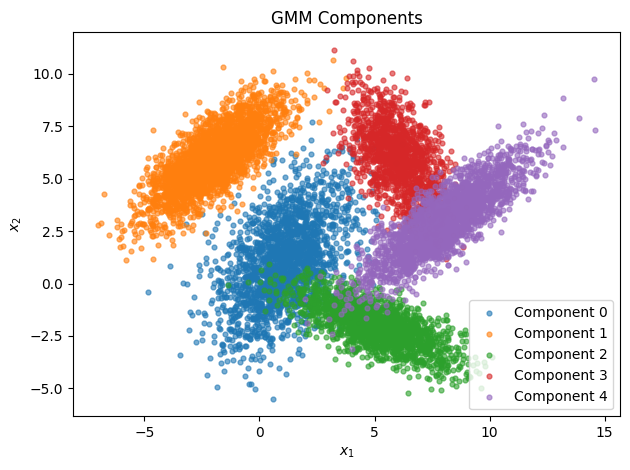

In [10]:
sizes = [2.25,3,2,1.5,2.5]
proportions = sizes / np.sum(sizes)
N= 10000

# component 1
count1 = (int)(N * proportions[0])
Σ1 = np.array([[2,1.3],[1.3,4]])
μ1 = np.array([1,1])
X1 = np.random.multivariate_normal(μ1, Σ1, size=count1)
y1 = np.zeros((count1))

# component 2
count2 = (int)(N * proportions[1])
Σ2 = np.array([[2,1.5],[1.5,2]])
μ2 = np.array([-2,6])
X2 = np.random.multivariate_normal(μ2, Σ2, size=count2)
y2 = 1 * np.ones((count2))

# component 3
count3 = (int)(N * proportions[2])
Σ3 = np.array([[3,-1.2],[-1.2,1]])
μ3 = np.array([5,-2])
X3 = np.random.multivariate_normal(μ3, Σ3, size=count3)
y3 = 2 * np.ones((count3))

# component 4
count4 = (int)(N * proportions[3])
Σ4 = np.array([[1,-0.75],[-0.75,2.4]])
μ4 = np.array([6,6])
X4 = np.random.multivariate_normal(μ4, Σ4, size=count4)
y4 = 3 * np.ones((count4))

# component 5
count5 = (int)(N * proportions[4])
Σ5 = np.array([[3,2.3],[2.3,2.5]])
μ5 = np.array([8,3])
X5 = np.random.multivariate_normal(μ5, Σ5, size=count5)
y5 = 4 * np.ones((count5))

Σ = np.array([Σ1,Σ2,Σ3,Σ4,Σ5])
μ = np.array([μ1,μ2,μ3,μ4,μ5])

X = np.vstack([X1, X2, X3, X4, X5])
y = np.concatenate([y1, y2, y3, y4, y5])

indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

X_train=X[:8000]
y_train=y[:8000]

X_test=X[8000:]
y_test=y[8000:]

plot_clusters(X,y,5)

In [79]:
dirpath = "./../../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

In [80]:
R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes = meanfield_vi(X_train,3)

In [81]:
zs = np.argmax(R, axis=1)

In [82]:
metrics.adjusted_rand_score(y_train, zs)

0.5610205963725792

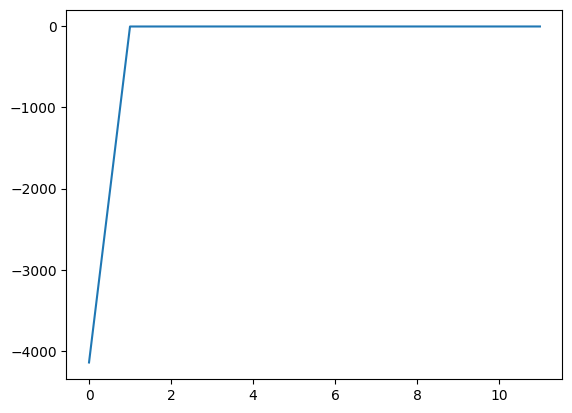

In [83]:
plt.plot(loglikes)

In [84]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [86]:
R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes = meanfield_vi(X_cover1,3)

In [87]:
zs = np.argmax(R, axis=1)
metrics.adjusted_rand_score(y_train, zs)

0.5194799057724978

# Appendix

## 1 Conditional Derivation of X_H

Let 
$$
    \mathbf{x}^n | z_n=k \sim \mathcal{N}(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)
$$
Where
$$\begin{align}
    & \mathbf{x}^n = \begin{bmatrix}\mathbf{x}^n_O \\  \mathbf{x}^n_H\end{bmatrix} \quad
      \boldsymbol{\mu}_k = \begin{bmatrix} \boldsymbol{\mu}_k^O \\ \boldsymbol{\mu}_k^H \end{bmatrix} \quad 
      \boldsymbol{\Sigma}_k = \begin{bmatrix} 
                                    \boldsymbol{\Sigma}_k^{OO} & \boldsymbol{\Sigma}_k^{OH}\\
                                    \boldsymbol{\Sigma}_k^{HO} & \boldsymbol{\Sigma}_k^{HH}
                              \end{bmatrix}
\end{align}$$
Then the quadratic term of $\mathcal{N}(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)$ becomes:

$$\begin{align}
    -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k) &= 
            -\frac{1}{2} \begin{bmatrix} 
                \mathbf{x}^n_O - \boldsymbol{\mu}_k^O\\
                \mathbf{x}^n_H - \boldsymbol{\mu}_k^H
            \end{bmatrix}^T \begin{bmatrix}
                \boldsymbol{\Lambda}_k^{OO} & \boldsymbol{\Lambda}_k^{OH}\\
                \boldsymbol{\Lambda}_k^{HO} & \boldsymbol{\Lambda}_k^{HH}
            \end{bmatrix} \begin{bmatrix} 
                \mathbf{x}^n_O - \boldsymbol{\mu}_k^O\\
                \mathbf{x}^n_H - \boldsymbol{\mu}_k^H
            \end{bmatrix}\\\\
        
        &= -\frac{1}{2}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)^T\boldsymbol{\Lambda}_k^{OO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
           -\frac{1}{2}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HH}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^H)
           - (\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
\end{align}$$